# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import pandas as pd
import sys
import doubletdetection
import tarfile
import time
from bhtsne import tsne
from sklearn.decomposition import PCA
import phenograph

## Download Data from 10x

In [2]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

--2018-04-17 17:12:58--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2600:9000:201a:3a00:1d:87c0:ff40:93a1, 2600:9000:201a:e800:1d:87c0:ff40:93a1, 2600:9000:201a:8000:1d:87c0:ff40:93a1, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2600:9000:201a:3a00:1d:87c0:ff40:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  6.78MB/s    in 5.5s    

2018-04-17 17:13:04 (6.46 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
%%capture

clf = doubletdetection.BoostClassifier(n_iters=50)

start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()

In [5]:
print('Time elapsed: {} seconds for {} iterations'.format(np.round(end-start, 2), clf.n_iters))

Time elapsed: 1136.55 seconds for 50 iterations


## Visualize Results

### Convergence of Doublet Calls

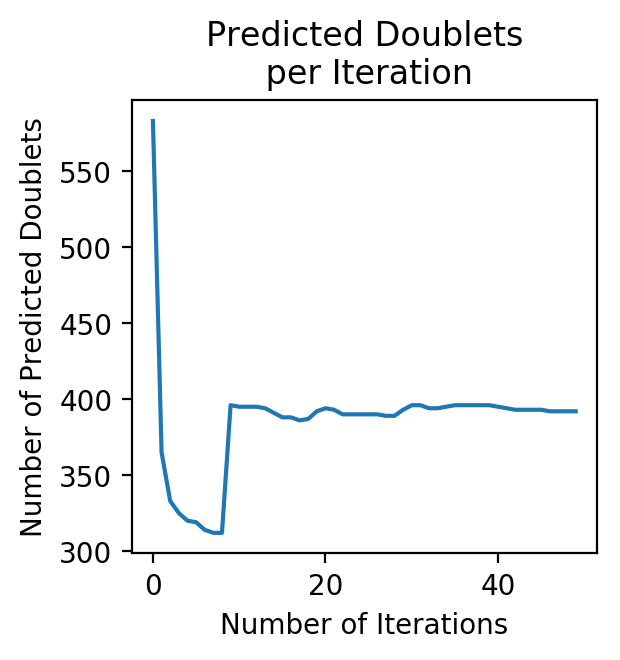

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True)

### Doublets on TSNE map

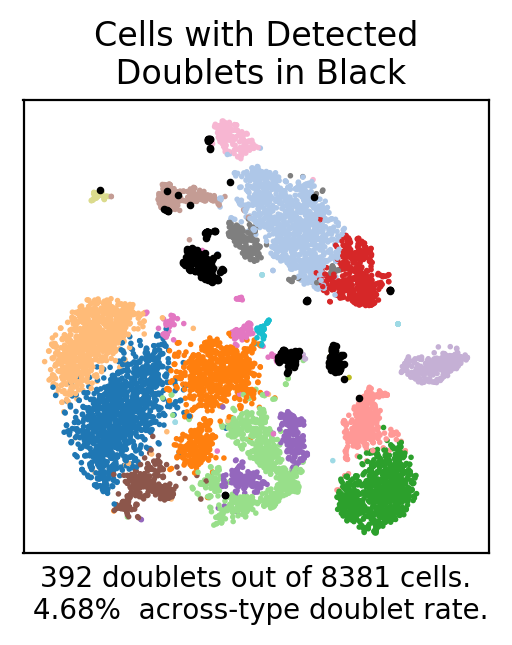

In [7]:
f2, tsne_coords = doubletdetection.plot.tsne(raw_counts, doublets, save='tsne_test.pdf', show=True)